# Выбор локации для скважины

Работая в добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

`id` — уникальный идентификатор скважины;\
`f0`, `f1`, `f2` — три признака точек;\
`product` — объём запасов в скважине (тыс. баррелей).

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
def profit(product):
    price = 450_000
    costs = 10_000_000_000
    return sum(product) * price - costs

def plot_features(data):   
    
    num_data = data.select_dtypes(include=['float64', 'int64'])
    
    count_num_features = len(num_data.columns)    
    fig, axes = plt.subplots(nrows=count_num_features, ncols=2, figsize=(12, 8))

    for i, column in enumerate(num_data.columns):
        sns.histplot(num_data[column], ax=axes[i, 0], bins=100) 
        axes[i, 0].set_title(f'Гистограмма {column}')
        
        sns.boxplot(num_data[column], ax=axes[i, 1])
        axes[i, 1].set_title(f'Ящик с усами {column}')

    plt.tight_layout()
    plt.show()

In [3]:
geo_data_0 = pd.read_csv(pth11)
geo_data_1 = pd.read_csv(pth21)
geo_data_2 = pd.read_csv(pth31)

Изучим данные.

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В каждом из трех датасетов имеется 100000 строк без пропусков. Данные загружены корректно и тип соответствует указанным значениям.

Изучим распределение признаков.

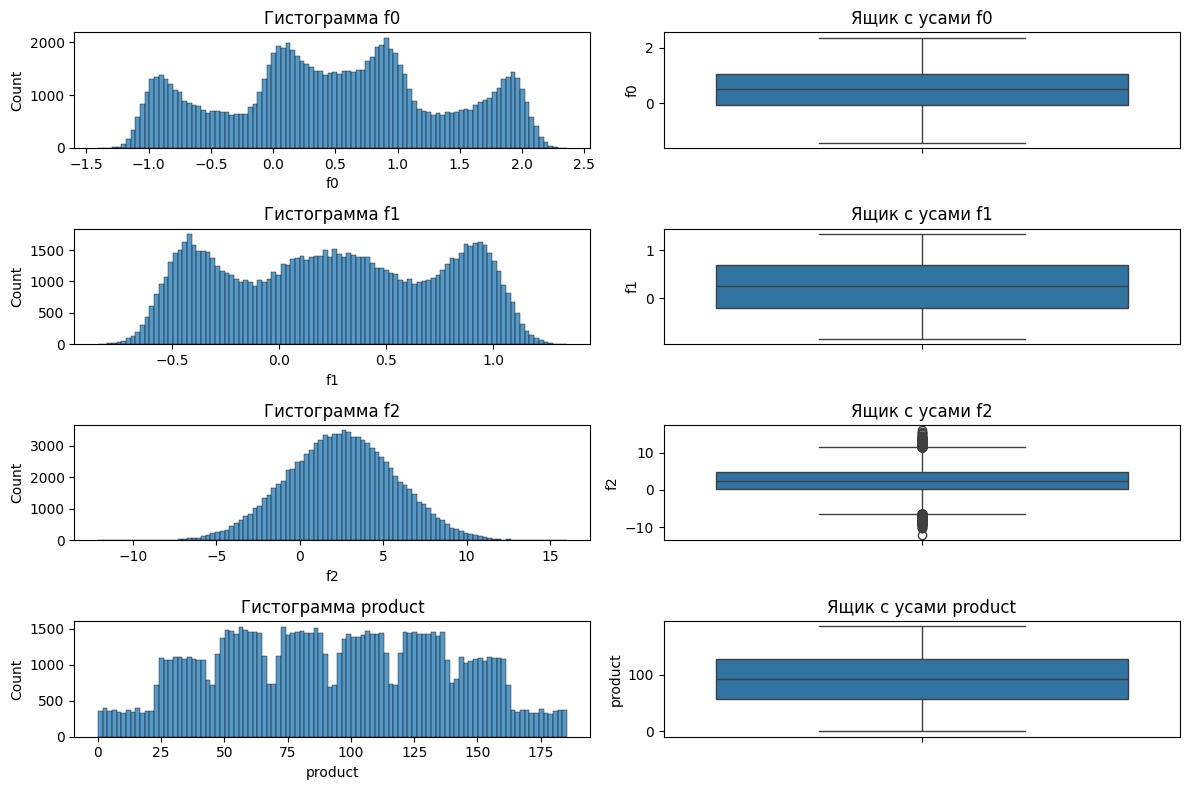

In [10]:
plot_features(geo_data_0)

В первом регионе признаки имеют распределение похожее на нормальное. f0 и f1 имеют несколько пиков близ целых числе. Распределение product напоминает забор с просадкой каждые 25 единиц.

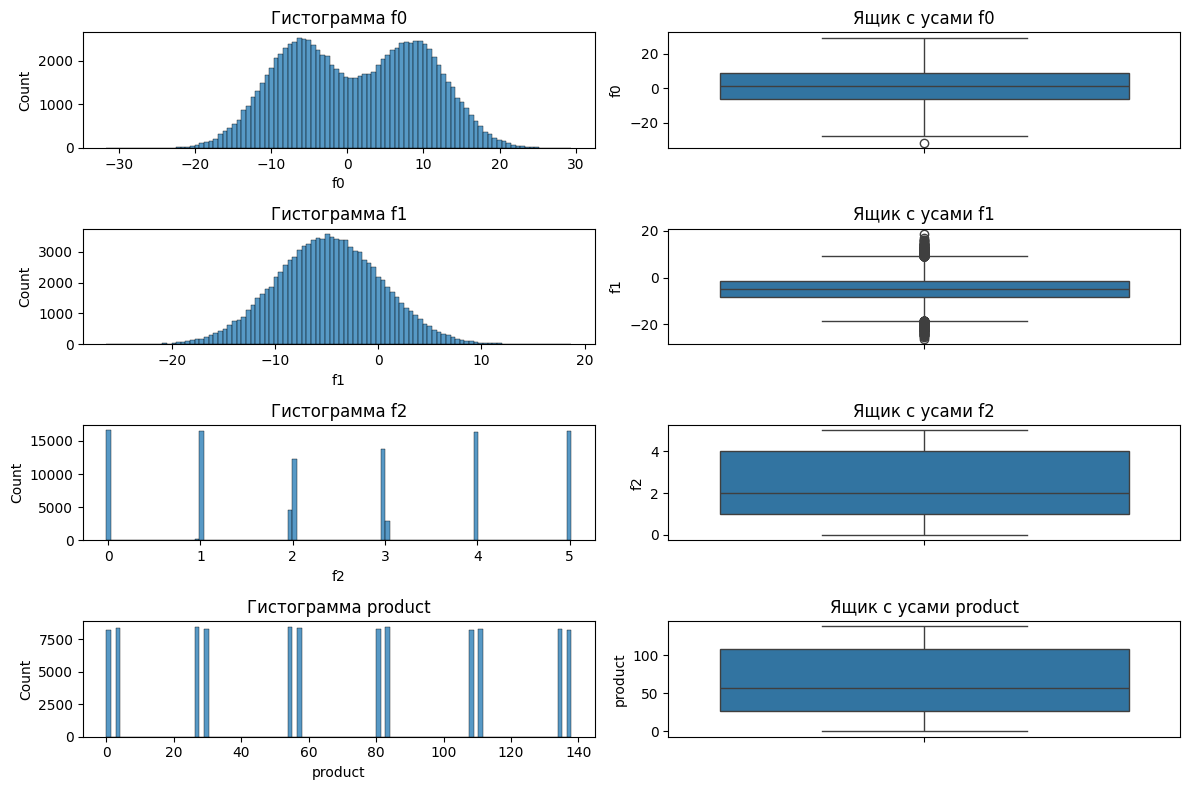

In [11]:
plot_features(geo_data_1)

Распределение по второму региону отличается от первого и выглядит подозрительно, признак f2 принимает дискретные значения, rак и product. Стоит уточнить, нет ли в данных ошибки. 

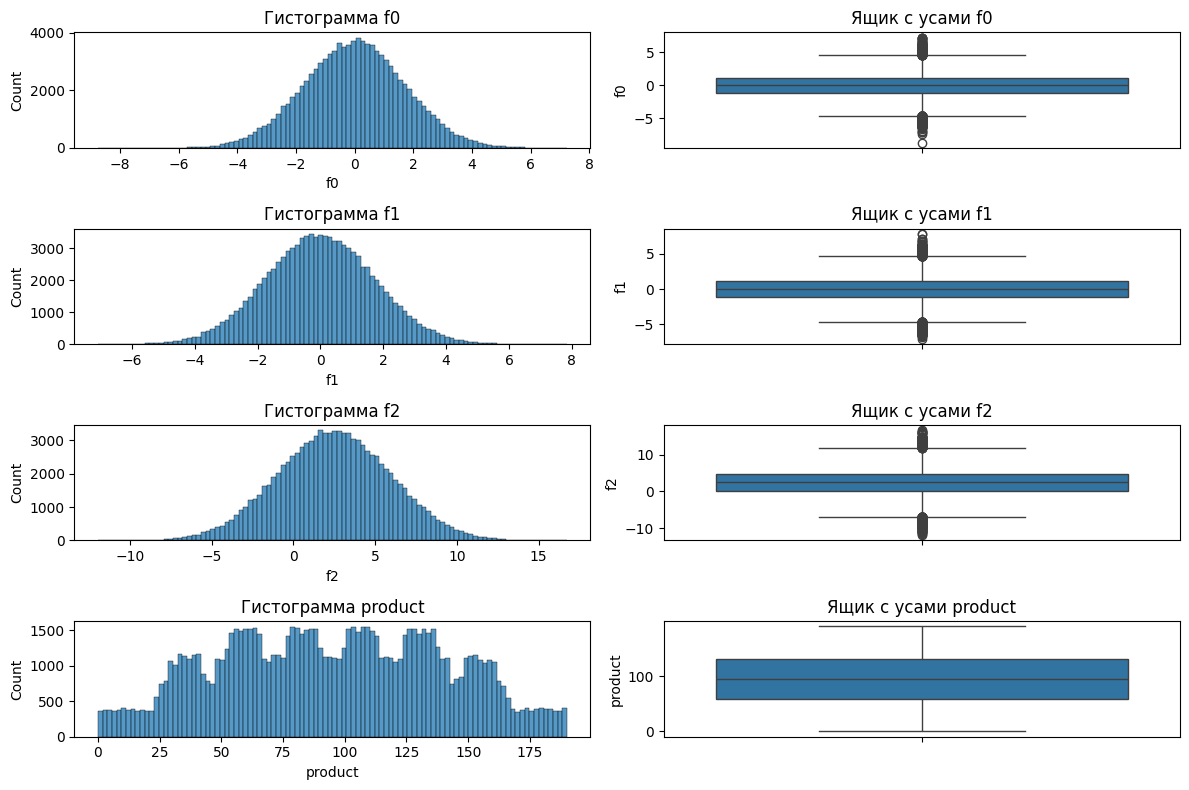

In [12]:
plot_features(geo_data_2)

По третьему региону наблюдаем нормальное распределение признаков. Распределение product похоже на первый регион.

Изучим корреляцию признаков.

Text(0.5, 1.0, 'Матрица корреляции признаков geo_data_0')

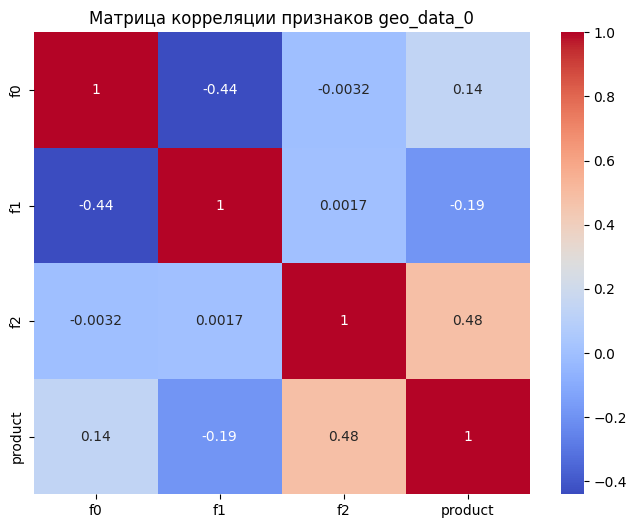

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(geo_data_0.drop('id', axis=1).corr(), cmap='coolwarm', annot=True)
plt.title('Матрица корреляции признаков geo_data_0')

Из всех признаков только f2 имеет среднюю корреляцию с целевым 0.48. Остальные почти не коррелируют, а f1 имеет очень слабую обратную корреляцию.

Text(0.5, 1.0, 'Матрица корреляции признаков geo_data_1')

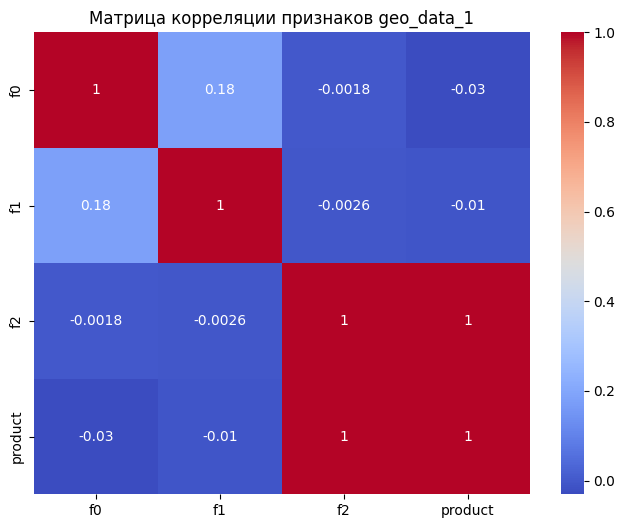

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(geo_data_1.drop('id', axis=1).corr(), cmap='coolwarm', annot=True)
plt.title('Матрица корреляции признаков geo_data_1')

В данных второго региона признак f2 имеет практически 100% линейную зависимость с целевым. Это очень странно.

Text(0.5, 1.0, 'Матрица корреляции признаков geo_data_2')

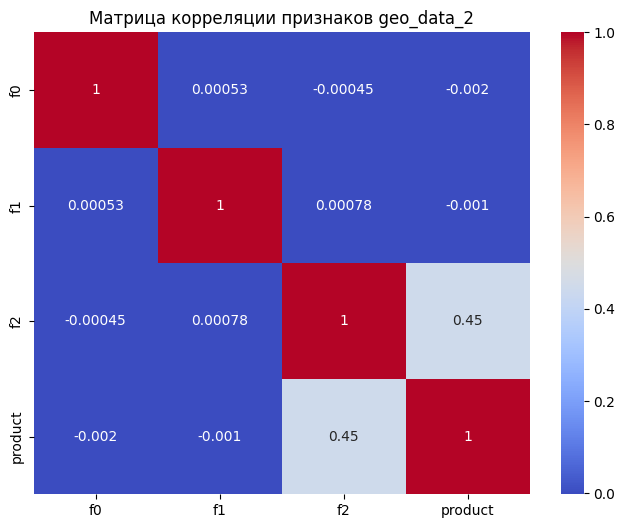

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(geo_data_2.drop('id', axis=1).corr(), cmap='coolwarm', annot=True)
plt.title('Матрица корреляции признаков geo_data_2')

В данных третьего региона нет корреляции признаков f0 и f1, имеется слабая корреляция 0.45 с признаком f2.

## Обучение и проверка модели

Разобьем данные на обучающую и валидационную выборки.

In [16]:
TEST_SIZE = 0.25
state = np.random.RandomState(42)

X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(geo_data_0.drop(['id', 'product'], axis=1),
                                                          geo_data_0['product'],
                                                          test_size=TEST_SIZE,
                                                          random_state=state)


X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(geo_data_1.drop(['id', 'product'], axis=1),
                                                          geo_data_1['product'],
                                                          test_size=TEST_SIZE,
                                                          random_state=state)


X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(geo_data_2.drop(['id', 'product'], axis=1),
                                                          geo_data_2['product'],
                                                          test_size=TEST_SIZE,
                                                          random_state=state)

Обучим модели и сделаем предсказание

In [17]:
def rmse_print(X_train, y_train, X_val, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    average = np.mean(y_pred)

    print('Средний запас предсказанного сырья:', average)
    print('RMSE:', rmse)
    print()

На данных из geo_data_0:

In [18]:
rmse_print(X_train_0, y_train_0, X_val_0, y_val_0)

Средний запас предсказанного сырья: 92.3987999065777
RMSE: 37.756600350261685



На данных из geo_data_1:

In [19]:
rmse_print(X_train_1, y_train_1, X_val_1, y_val_1)

Средний запас предсказанного сырья: 68.58780312701154
RMSE: 0.8899472027156135



На данyых из geo_data_2:

In [20]:
rmse_print(X_train_2, y_train_2, X_val_2, y_val_2)

Средний запас предсказанного сырья: 95.09230341410031
RMSE: 40.23735038140562



In [21]:
model_0 = LinearRegression()
model_0.fit(X_train_0, y_train_0)
y_pred_val_0 = model_0.predict(X_val_0)
rmse_0 = np.sqrt(mean_squared_error(y_val_0, y_pred_val_0))
average_0 = np.mean(y_pred_val_0)

print('Средний запас предсказанного сырья:', average_0)
print('RMSE модели на данных из "geo_data_0":', rmse_0)
print()


model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)
y_pred_val_1 = model_1.predict(X_val_1)
rmse_1 = np.sqrt(mean_squared_error(y_val_1, y_pred_val_1))
average_1 = np.mean(y_pred_val_1)

print('Средний запас предсказанного сырья:', average_1)
print('RMSE модели на данных из "geo_data_1":', rmse_1)
print()


model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)
y_pred_val_2 = model_2.predict(X_val_2)
rmse_2 = np.sqrt(mean_squared_error(y_val_2, y_pred_val_2))
average_2 = np.mean(y_pred_val_2)

print('Средний запас предсказанного сырья:', average_2)
print('RMSE модели на данных из "geo_data_2":', rmse_2)

Средний запас предсказанного сырья: 92.3987999065777
RMSE модели на данных из "geo_data_0": 37.756600350261685

Средний запас предсказанного сырья: 68.58780312701154
RMSE модели на данных из "geo_data_1": 0.8899472027156135

Средний запас предсказанного сырья: 95.09230341410031
RMSE модели на данных из "geo_data_2": 40.23735038140562


В дальнейшем нам потребуются предсказанные значения, поэтому не будем оборачивать код в цикл. Сравнение метрики RMSE трех моделей на трех различных данных показало, что ближе к истинному таргету результаты имеет модель на данных региона `geo_data_1` с метрикой 0.89. При этом средний запас сырья лидирует на третьем регионе со значением 95.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [22]:
BUDGET = 10_000_000_000
WELL_COUNT = 200
PRICE = 450_000

BUDGET/WELL_COUNT/PRICE

111.11111111111111

Сравним его со средним запасом в каждом регионе.

In [23]:
print('Регион 1:', np.mean(y_val_0))
print('Регион 2:', np.mean(y_val_1))
print('Регион 3:', np.mean(y_val_2))

Регион 1: 92.32595637084387
Регион 2: 68.59968732439852
Регион 3: 95.03521872476617


Необходимый объем сырья для безубыточной разработки скважины должен быть не менее 111.1 тыс. баррелей. Среднее значение ни одного из регионов не достигает необходимого уровня объема производства.

## Расчёт прибыли и рисков 

In [24]:
region_one = pd.concat([X_val_0, y_val_0], axis=1)
region_one['predicted'] = y_pred_val_0

region_two = pd.concat([X_val_1, y_val_1], axis=1)
region_two['predicted'] = y_pred_val_1

region_three = pd.concat([X_val_2, y_val_2], axis=1)
region_three['predicted'] = y_pred_val_2

In [25]:
print('Прибыль региона 1:', profit(region_one[['product', 'predicted']].sort_values(by='predicted', ascending=False)['product'].head(WELL_COUNT)))
print('Прибыль региона 2:', profit(region_two[['product', 'predicted']].sort_values(by='predicted', ascending=False)['product'].head(WELL_COUNT)))
print('Прибыль региона 3:', profit(region_three[['product', 'predicted']].sort_values(by='predicted', ascending=False)['product'].head(WELL_COUNT)))

Прибыль региона 1: 3359141114.462179
Прибыль региона 2: 2415086696.681507
Прибыль региона 3: 2584156887.1524086


Лидером по прибыли является первый регион, затем третий и с небольшим отрывом второй.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [26]:
N_SAMPLES = 500

profit_distribution_0 = []
for i in range(1000):
    
    wells = region_one[['product', 'predicted']].sample(n=N_SAMPLES, replace=True, random_state=state).sort_values(by='predicted', ascending=False)['product'].head(WELL_COUNT)
    profit_distribution_0.append(profit(wells))
    
profit_distribution_0 = pd.Series(profit_distribution_0)

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков для первого региона.

In [27]:
print('Среднее значение прибыли первого региона:',profit_distribution_0.mean())
print('Нижний квантиль 2,5%:', profit_distribution_0.quantile(0.025))
print('Верхний квантиль 97,5%:', profit_distribution_0.quantile(0.975))

Среднее значение прибыли первого региона: 415660639.0640569
Нижний квантиль 2,5%: -136326160.40477782
Верхний квантиль 97,5%: 932343968.2576677


95%-й доверительный интервал прибыли для первого региона составляет от -136 до 932 млн. Среднее значение прибыли 415 млн, но так как существует риск убытка выше 2,5%, то данный регион не подойдет.


Найдем значения для второго региона.

In [28]:
profit_distribution_1 = []
for i in range(1000):
    
    wells = region_two[['product', 'predicted']].sample(n=N_SAMPLES, replace=True, random_state=state).sort_values(by='predicted', ascending=False)['product'].head(WELL_COUNT)
    profit_distribution_1.append(profit(wells))
    
profit_distribution_1 = pd.Series(profit_distribution_1)

print('Среднее значение прибыли второго региона:',profit_distribution_1.mean())
print('Нижний квантиль 2,5%:', profit_distribution_1.quantile(0.025))
print('Верхний квантиль 97,5%:', profit_distribution_1.quantile(0.975))

Среднее значение прибыли второго региона: 429544618.0738954
Нижний квантиль 2,5%: 37480969.5798461
Верхний квантиль 97,5%: 813804862.100483


95%-й доверительный интервал прибыли для второго региона составляет от 37 до 814 млн. Среднее значение прибыли 430 млн. Данный регион выглядит надежным.

Найдем значения для третьего региона.

In [29]:
profit_distribution_2 = []
for i in range(1000):
    
    wells = region_three[['product', 'predicted']].sample(n=N_SAMPLES, replace=True, random_state=state).sort_values(by='predicted', ascending=False)['product'].head(WELL_COUNT)
    profit_distribution_2.append(profit(wells))
    
profit_distribution_2 = pd.Series(profit_distribution_2)

print('Среднее значение прибыли третьего региона:',profit_distribution_2.mean())
print('Нижний квантиль 2,5%:', profit_distribution_2.quantile(0.025))
print('Верхний квантиль 97,5%:', profit_distribution_2.quantile(0.975))

Среднее значение прибыли третьего региона: 318153092.23118144
Нижний квантиль 2,5%: -227793511.68089724
Верхний квантиль 97,5%: 813881577.9546496


95%-й доверительный интервал прибыли для третьего региона составляет от -228 до 814 млн. Среднее значение прибыли 318 млн. Данный регион не выглядит надежным, так как существует риск убытков.

Сравним вероятность получить убыток при разработке регионов.

In [30]:
print(f'Риск убытков первого региона: {(profit_distribution_0 < 0).mean() * 100}%')
print(f'Риск убытков второго региона: {(profit_distribution_1 < 0).mean() * 100}%')
print(f'Риск убытков третьего региона: {(profit_distribution_2 < 0).mean() * 100}%')

Риск убытков первого региона: 6.2%
Риск убытков второго региона: 1.5%
Риск убытков третьего региона: 12.3%


На третьем ригионе максимальная вероятность в 12,3% получить отрицательную прибыль, также высокий риск и в первом регионе, а второй со значением 1,5% подходит по критерию успеха задания в 2,5% риска.

Итак, второй регион лидирует, третий и первый имеют высокий риск убытков.

## Выводы

В данном исследовании была поставлена задача выбрать регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. 

Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.1 тыс баррелей. Средний объем сырья в скважине зависимости от региона составляет от 68 до 95 тыс баррелей, что не достигает требуемого значения. Для прибыльного производства необходимо разработать модель, которая сможет давать прогнозы по уровню добычи лучше, чем среднее значение.

1. Первый регион. Суммарная прибыль 200 лучших скважин региона региона в соответствии с предсказаниями модели составляет 3,359 млрд. Метрика RMSE 37,76. По расчету распределения прибыли с помощью семплирования 95%-й доверительный интервал от -136 млн до 932 млн прибыли. Распределение признаков имеет несколько пиков возле дискретных значений. Риск убытков 6,2%.
2. Второй регион. Суммарная прибыль составляет 2,415 млрд. Метрика RMSE 0,889. 95%-й доверительный интервал от 37 до 814 млн прибыли. Признак f2 принимает дискретные значения и имеет практически 100% корреляцию с целевым. Риск убытков  1,5%.
3. Третий регион. Суммарная прибыль составляет 2,584 млрд. Метрика RMSE 40.24. 95%-й доверительный интервал от -228 до 814 млн прибыли. Риск убытков 12,3%.

200 лучших предсказанных скважин по всему первому региону опережают по прибыли второй и третий регион почти на миллиард, но 95% доверительный интервал выше у второго региона, что делает его наименее рискованным. Также у второго региона наивысшее значение распределения средней прибыли в 430 млн.

С учетом подозрительного распределения признаков датафрейма второго региона, рекомендуется проверить корректность признака f2, который линейно коррелирует с product. Если в данных будет выявлена ошибка, тогда ни один из регионов не подгодит по критерию успеха, не превышать риск убытков более, чем на 2,5%. В таком случае стоит рассмотреть, либо другие регионы, либо выделить дополнительный бюджет, чтобы в разведку входило не 500, а 1000 скважин. Среди такого количества выборка 200 лучших даст больший прирост прибыли, что снизит риск убытков. Если же данные второго региона правильные, то его стоит выбрать для разработки.